# Diversified vs. Tech only Portfolios Analysis (ETFs)

## Project Setup

This notebook requires several Python libraries. They can be installed via:
```bash
pip install -r requirements.txt
```
Helper functions are imported from 'utils.py'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.stats as stats
import os
from datetime import datetime
import pandas_datareader.data as web
import statsmodels.api as sm

#some functions are imported from separate utils.py for clarity of steps taken during analysis
from utils import get_data, quarterly_rebalancing, downside_deviation

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
%config InlineBackend.figure_format = 'retina'

## Project scope

What this project **is**:
This project is an attempt to enhance understanding and learn to visualize key performance metrics of modern portfolio theory, as well as analyze return vs risk dynamics in diversification strategy of ETFs investments. To achieve this, a comparison between portfolio consisting of tech companies only ETF (XLK) and equal-weight diversified by different industry sectors ETFs portfolio is conducted.
Area of analysis:
- Market: US
- Weights rebalancing: quarterly 
- Period: from beginning of 2014 to the end of 2024.

What this project **isn't**:
This project is not an attempt to figure out best possible portfolio for abovementioned period of time or any future period, however it lays foundations for such work in the future.

## Data acquisition

This analysis utilizes historical price data sourced from Yahoo Finance via the yfinance Python API. While this provides a robust and accessible dataset for illustrative and educational purposes, it is important to note that professional financial institutions typically rely on premium data feeds from vendors like Bloomberg or Refinitiv for institutional-grade analysis, which offer greater precision.

This project is scripted in a way, so that the user/reader can modify the tickers table below to one's liking, while keeping 'XLK' and 'SPY' in it. Following ETFs were chosen for building diversified portfolio, diversifying by industry sectors.

| Ticker | Full-name | Description | Key holdings | Theoretical advantage
| :-: | :- | :- |:- | :- |
| XLK | Technology Select Sector SPDR Fund (State Street) | The U.S. technology sector. Technology and telecom companies from the S&P 500 | Apple, Microsoft, Nvidia, Broadcom, Adobe | Pure-play, growth-oriented, high volatility |
| XLF | Financial Select Sector SPDR Fund (State Street) | The U.S. financial services sector. Banks, capital markets, insurance, and consumer finance | Berkshire Hathaway, JPMorgan Chase, Visa, Mastercard, Bank of America | Performs well in a rising interest rate environment |
| XLE | Energy Select Sector SPDR Fund (State Street) | The U.S. energy sector. Oil, gas, and consumable fuels; energy equipment & services | Exxon Mobil, Chevron, ConocoPhillips, Schlumberger | A classic diversifier against tech. Often has a low or negative correlation with XLK, strong positive correlation with oil prices |
| XLV | Health Care Select Sector SPDR Fund (State Street) | The U.S. healthcare sector. Pharmaceuticals, biotechnology, medical devices, healthcare providers | UnitedHealth Group, Johnson & Johnson, Eli Lilly, Pfizer, Abbott Labs | A defensive "recession-resistant" sector. People need healthcare regardless of the economy |
| XLI | Industrial Select Sector SPDR Fund (State Street) | The U.S. industrial sector. Aerospace, defense, machinery, road & rail, industrial conglomerates | Honeywell, Union Pacific, Boeing, Raytheon, Caterpillar | Provides exposure to domestic and global economic growth and manufacturing |
| XLP | Consumer Staples Select Sector SPDR Fund (State Street) | The U.S. consumer staples sector. Food & staples retailing, beverages, tobacco, household products | Procter & Gamble, Coca-Cola, Walmart, PepsiCo, Costco | Very defensive, stable demand, low growth |
| XLU | Utilities Select Sector SPDR Fund (State Street) | The U.S. utilities sector. Electric, gas, and water utilities, independent power producers | NextEra Energy, Southern Co, Duke Energy, Dominion Energy | Another strong defensive sector. Low growth but very low volatility |

For data acqusition a get_data() funcion is used, imported from utils.py file. It checks whether the prices data is already saved locally, if not it utilizes yahoo finance API, cleans price data of any NAs and ensures proper dates formatting and saves the data.

In [2]:
tickers = ['XLK', 'SPY', 'XLF', 'XLE', 'XLV', 'XLI', 'XLP', 'XLU'] #can be any number of tickers, SPY and XLK must be in, diversified portfolio will be created with the rest of tickers
start_date = '2014-01-01'
end_date = '2024-12-31'
prices_df = get_data(tickers, start_date, end_date) #get_data function in utils.py
prices_df.head()

Loading data from local file...


,SPY,XLE,XLF,XLI,XLK,XLP,XLU,XLV
Date,,,,,,,,
2014-01-02,149.840530,56.203926,14.236197,41.767387,30.573997,31.333782,25.677317,45.763630
2014-01-03,149.815994,55.997787,14.334420,41.880863,30.427132,31.274738,25.594910,45.871532
2014-01-06,149.381851,56.075111,14.347518,41.637684,30.375305,31.156631,25.636116,45.680614
2014-01-07,150.299271,56.500244,14.354069,41.897072,30.651747,31.326403,25.862732,46.162067
2014-01-08,150.332031,56.107292,14.399901,41.824120,30.651747,31.090199,25.725388,46.568813


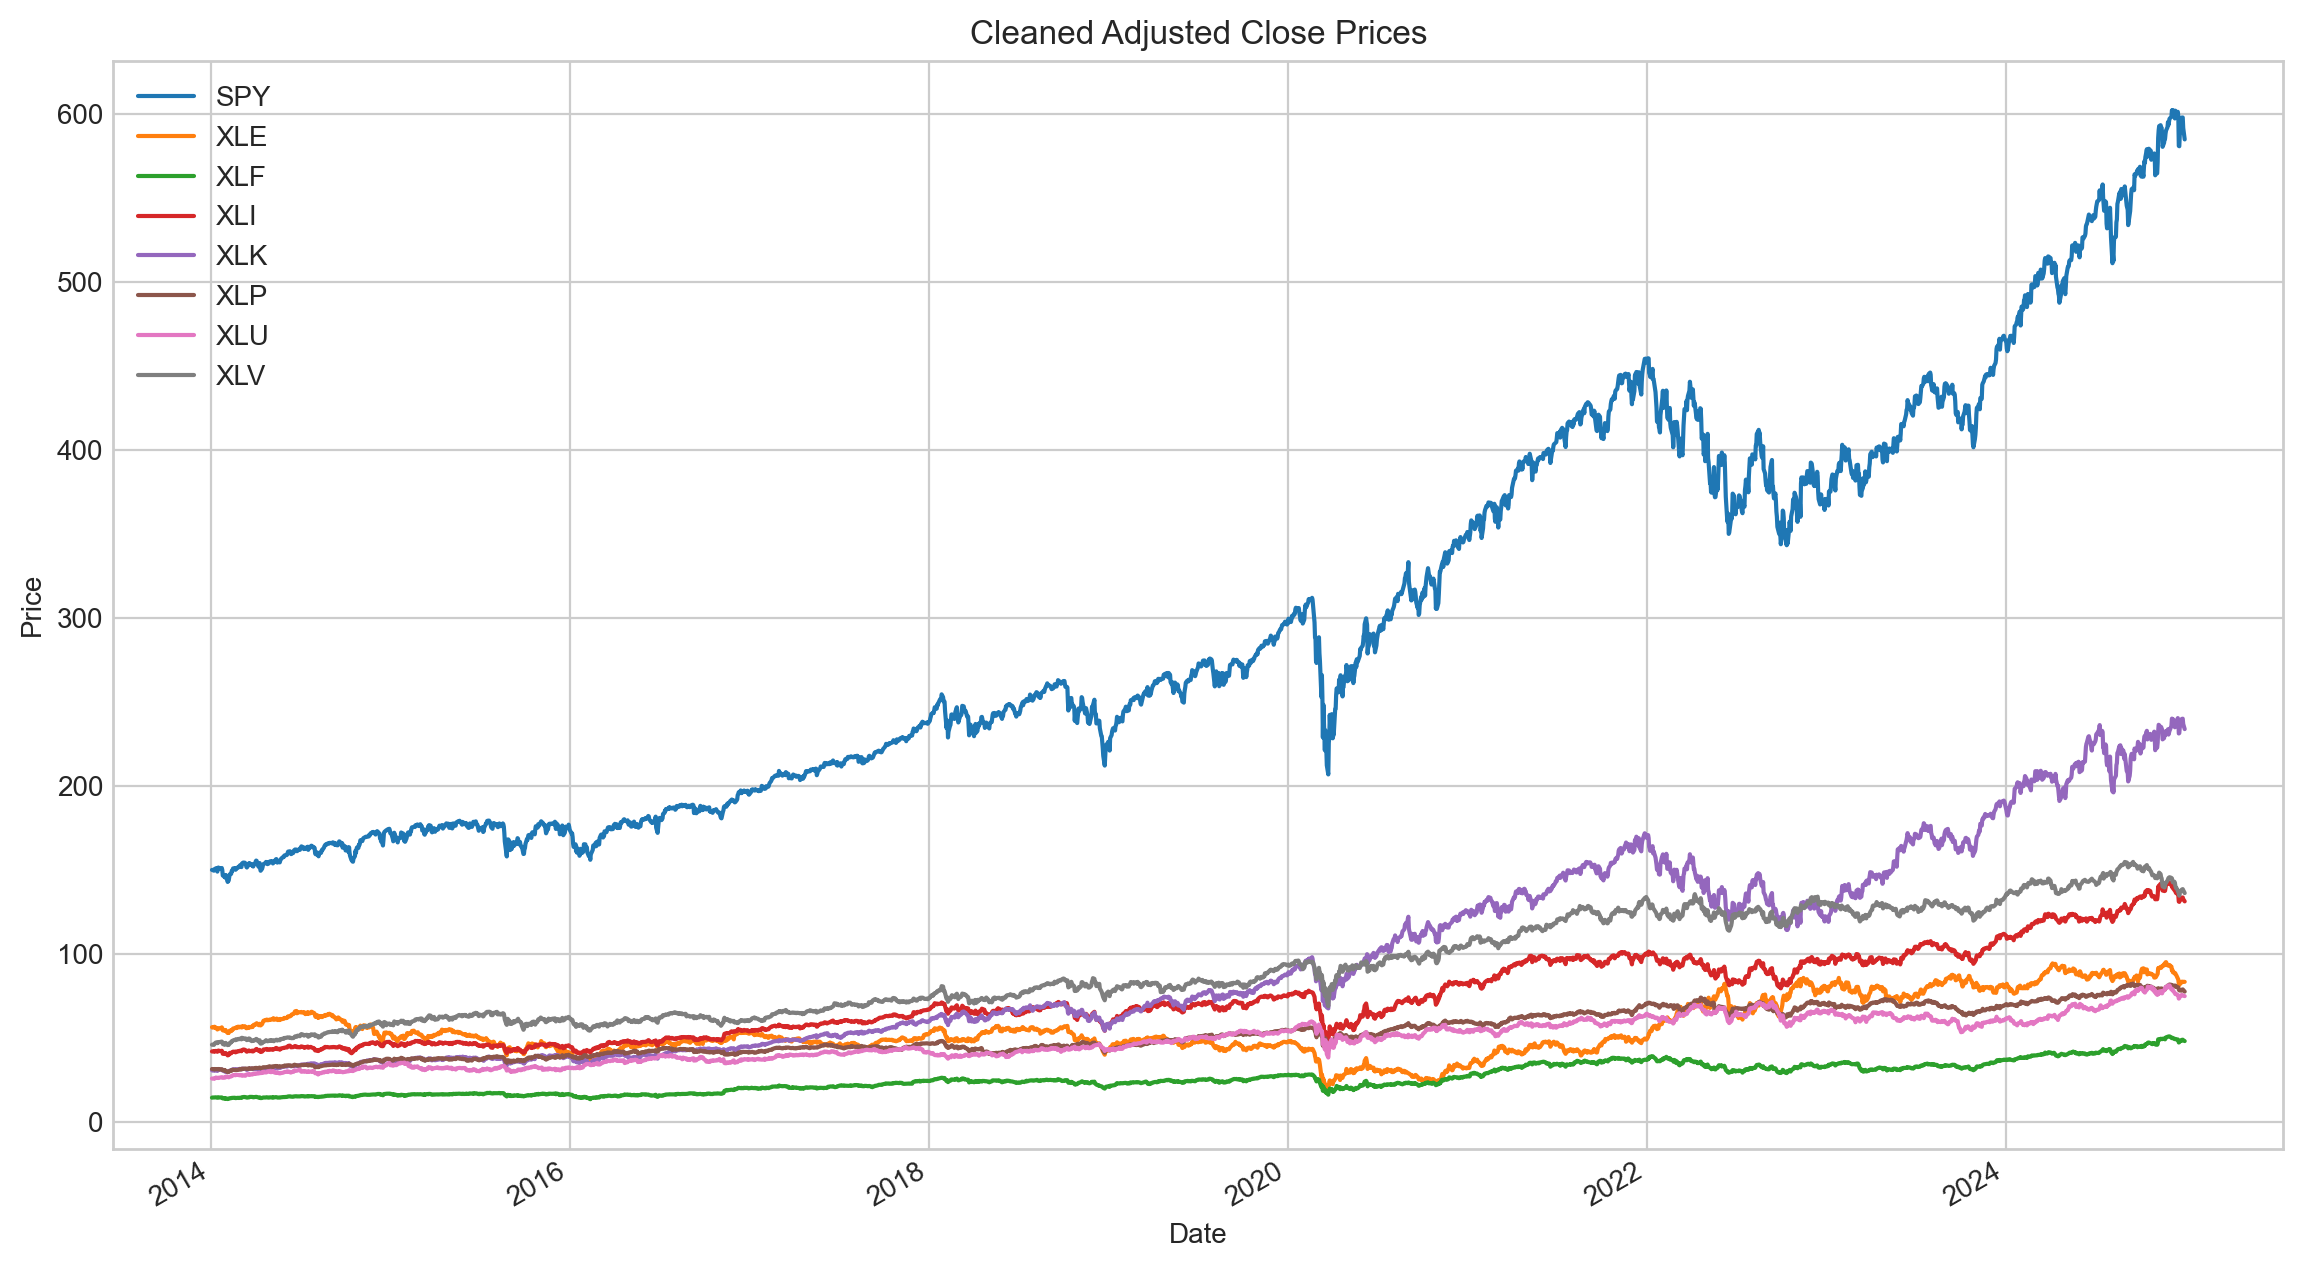

In [3]:
#Plot the data quickly to check for any outstanding issues after data cleaning:
prices_df.plot(title = 'Cleaned Adjusted Close Prices', figsize = (14, 8))
plt.ylabel('Price');

## Analysis

The calculation of daily returns and equity throughout the analyzed period were performed to begin with. The performance of the All-Tech (XLK) and Benchmark (SPY) portfolios was calculated using a straightforward buy-and-hold strategy.

For the Diversified portfolio, a custom quarterly_rebalancing() function (imported from utils.py) was used to simulate an investment strategy. This function iterates through each trading day. On most days, the portfolio value simply fluctuates with the market. On the last trading day of each quarter, a rebalancing event is triggered:
- The total value of the portfolio is calculated,
- The difference between the current value of each asset and its target value (total portfolio value × target weight) is calculated. The sum of the absolute values of these differences represents the total amount of assets that need to be bought or sold.
- A total transaction cost is calculated by applying a small slippage percentage to this total trade value.
- The remaining capital is then redistributed according to the target weights, effectively resetting the portfolio to its desired allocation.

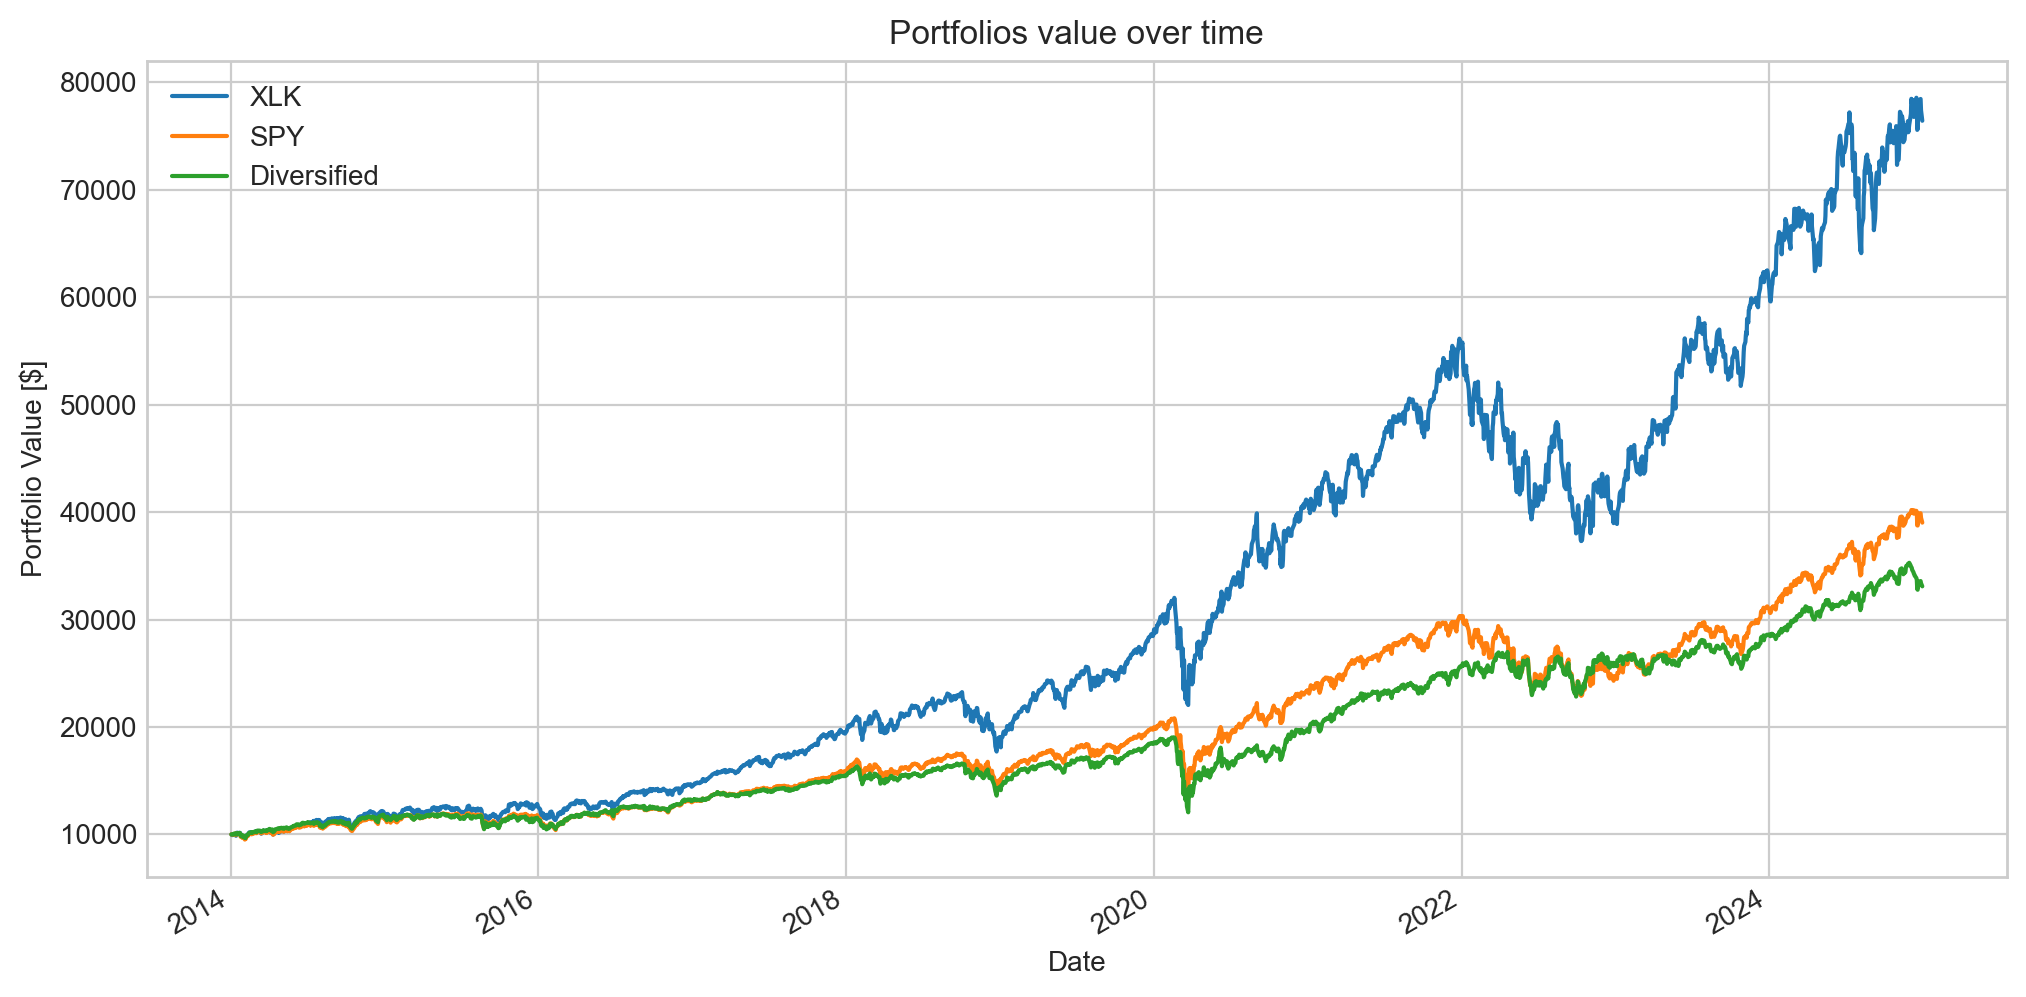

In [4]:
returns_df = prices_df.pct_change() #daily returns for each ETF
returns_df.iloc[0] = 0 #without this first row of .pct_change() method would be NaN resulting in issues later
initial_capital = 10000 #can be any number, it doesn't influence the analysis

tech_returns = returns_df['All-tech (XLK)']
tech_equity = (1 + tech_returns).cumprod()
tech_equity *= initial_capital
tech_equity.plot()

bench_returns = returns_df['Benchmark SPY']
bench_equity = (1 + bench_returns).cumprod()
bench_equity *= initial_capital
bench_equity.plot()

div_tickers = [i for i in tickers if i != 'SPY'] #create portfolio of remaining tickers
target_weights = np.array([1/len(div_tickers)] * len(div_tickers))
div_equity, div_returns = quarterly_rebalancing(returns_df, div_tickers, target_weights, initial_capital);

div_equity.plot(title = 'Portfolios value over time',label = 'Diversified')
plt.ylabel('Portfolio Value [$]')
plt.legend();

Portfolios value over time plot offers first insights to the comparison. Overall the equal-weight diversified portfolio underperformed the concentrated Tech portfolio and the SPY benchmark in terms of absolute return over the period. We can clearly see the two critical periods: Covid crash and 2022 bear market during which from first glance the diversified portfolio seems to achieve greater resilliance to the market stress, altough not so much during Covid drawdown. Let's investigate further.

In [5]:
#Compound Annual Growth Rates calculations:
tech_cagr_pct = (tech_equity.iloc[-1]/initial_capital)**(1/10) - 1
bench_cagr_pct = (bench_equity.iloc[-1]/initial_capital)**(1/10) - 1
div_cagr_pct = (div_equity.iloc[-1]/initial_capital)**(1/10) - 1
print(f'CAGR for all-tech (XLK) porfolio: {tech_cagr_pct:.2%} \nCAGR for benchmark S&P500 porfolio: {bench_cagr_pct:.2%} \nCAGR for diversified porfolio: {div_cagr_pct:.2%}')

CAGR for tech only (XLK) porfolio: 22.55% 
CAGR for benchmark S&P500 porfolio: 14.59% 
CAGR for diversified porfolio: 12.71%


The Compound Annual Growth Rates calculations allow us to move from visual observation to precise measurement.

- The technology sector (XLK) was the clear performance leader, achieving a remarkable 22.55% annualized return,
- The market (SPY) also performed strongly, returning 14.59%,
- The equal-weight diversified portfolio delivered a more moderate 12.73% return.

This establishes the fundamental trade-off. The concentrated tech strategy captured superior growth but likely did so by taking on greater risk, exhibiting greater volatility. The diversified strategy sacrificed absolute return, presumably for a reduction in risk. The next step is to quantify that risk to understand the full nature of this trade-off.

In [6]:
#returns volatility calculations:
tech_daily_volatility = tech_returns.std()
bench_daily_volatility = bench_returns.std()
div_daily_volatility = div_returns.std()

tech_annual_volatility = tech_daily_volatility * np.sqrt(252) #252 trading days in a year on average
bench_annual_volatility = bench_daily_volatility * np.sqrt(252)
div_annual_volatility = div_daily_volatility * np.sqrt(252)

print(f'Annual volatility for all-tech (XLK) portfolio: {tech_annual_volatility:.2%} \nAnnual volatility for benchmark S&P500 portfolio: {bench_annual_volatility:.2%} \nAnnual volatility for diversified portfolio: {div_annual_volatility:.2%}')

Annual volatility for tech only (XLK) portfolio: 22.54% 
Annual volatility for benchmark S&P500 portfolio: 17.13% 
Annual volatility for diversified portfolio: 16.35%


The annualized volatility figures quantify the risk dimension of the trade-off. The tech portfolio was significantly more volatile (23%) than both the broad market (17%) and the diversified portfolio (16%). While the strong positive return suggests a favorable distribution overall, the distribution plot will reveal the structure of this volatility, specifically, the moves in both directions, which is a key characteristic of high-risk, high-reward assets.

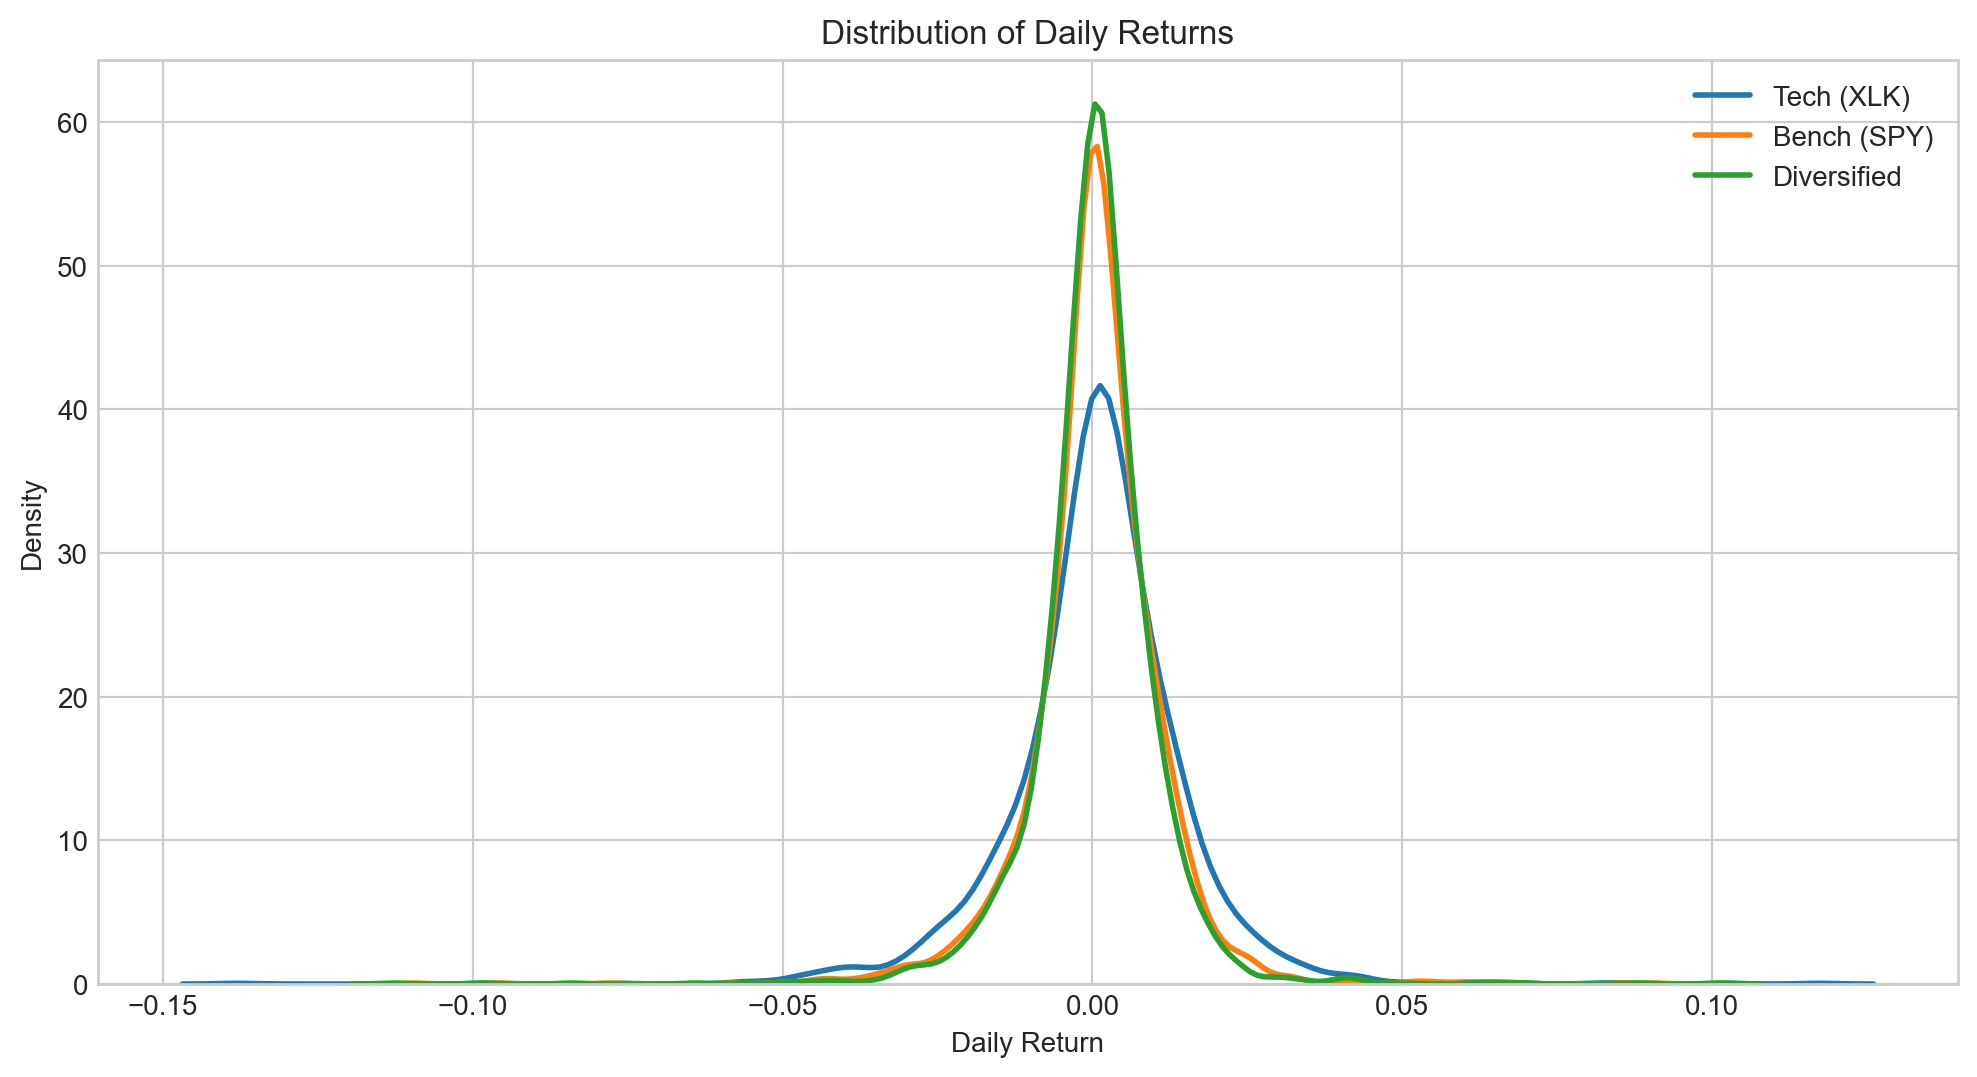

In [7]:
sns.kdeplot(tech_returns, label='All-Tech (XLK)', linewidth = 2)
sns.kdeplot(bench_returns, label='Benchmark (SPY)', linewidth = 2)
sns.kdeplot(div_returns, label='Diversified', linewidth = 2)

plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.legend()
plt.show()

Distribution plot sort of completes the picture that the numbers began to draw. All three have a positive skew, just confirming what we already knew from the strong overall performance. However, for the tech portfolio, this positive skew is paired with fat tails. This combination is the statistical signature of many small-to-moderate gains, punctuated by a few bigger gains and losses. The diversified portfolio's thinner tails indicate a more predictable profile. 
To quantify the worst-case losses experienced by an investor, let's calculate the Maximum Drawdown for each portfolio. This measures the largest peak-to-trough decline from the equity curve's running maximum. 

In [8]:
#Maximum Drawdown calculations:
tech_equity_runnimg_max = tech_equity.cummax()
tech_dd_series = (tech_equity/tech_equity_runnimg_max) - 1
tech_max_dd = tech_dd_series.min()

bench_equity_runnimg_max = bench_equity.cummax()
bench_dd_series = (bench_equity/bench_equity_runnimg_max) - 1
bench_max_dd = bench_dd_series.min()

div_equity_runnimg_max = div_equity.cummax()
div_dd_series = (div_equity/div_equity_runnimg_max) - 1
div_max_dd = div_dd_series.min()

print(f'Maximum Drawdown for all-tech (XLK) porfolio: {tech_max_dd:.2%}\nMaximum Drawdown for benchmark S&P500 porfolio: {bench_max_dd:.2%}\nMaximum Drawdown for diversified porfolio: {div_max_dd:.2%}')

Maximum Drawdown for tech only (XLK) porfolio: -33.56%
Maximum Drawdown for benchmark S&P500 porfolio: -33.72%
Maximum Drawdown for diversified porfolio: -36.62%


Results are are quite suprising, turns out diversified portfolio experienced largest Maximum Drawdown of the group. Let's plot the drawdown series for each portfolio and zoom in on specific stress period during which drawdowns are expected to be the largest to draw deeper conlcusions.

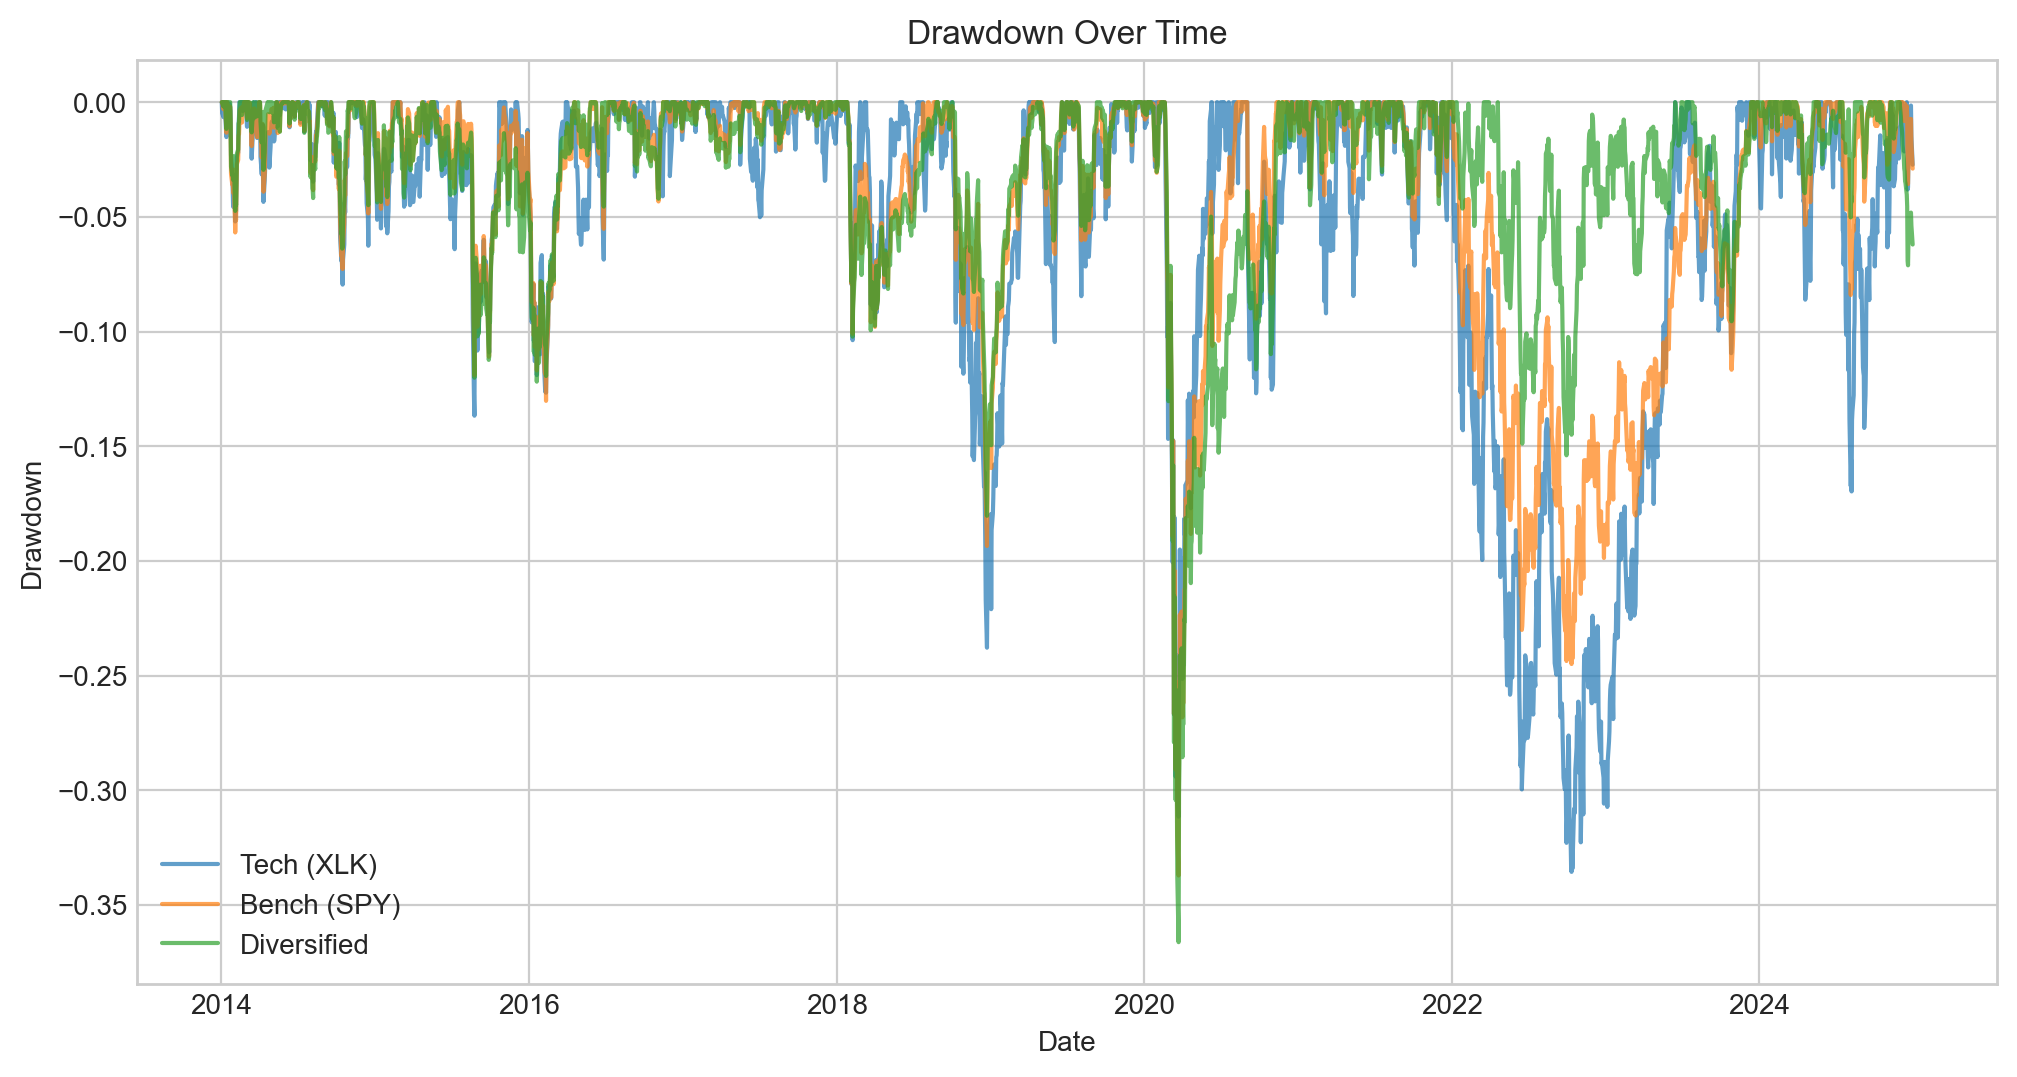

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(tech_dd_series, label='All-Tech (XLK)', alpha=0.7)
plt.plot(bench_dd_series, label='Benchmark (SPY)', alpha=0.7)
plt.plot(div_dd_series, label='Diversified', alpha=0.7)

plt.title('Drawdown Over Time')
plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.legend()
plt.show()

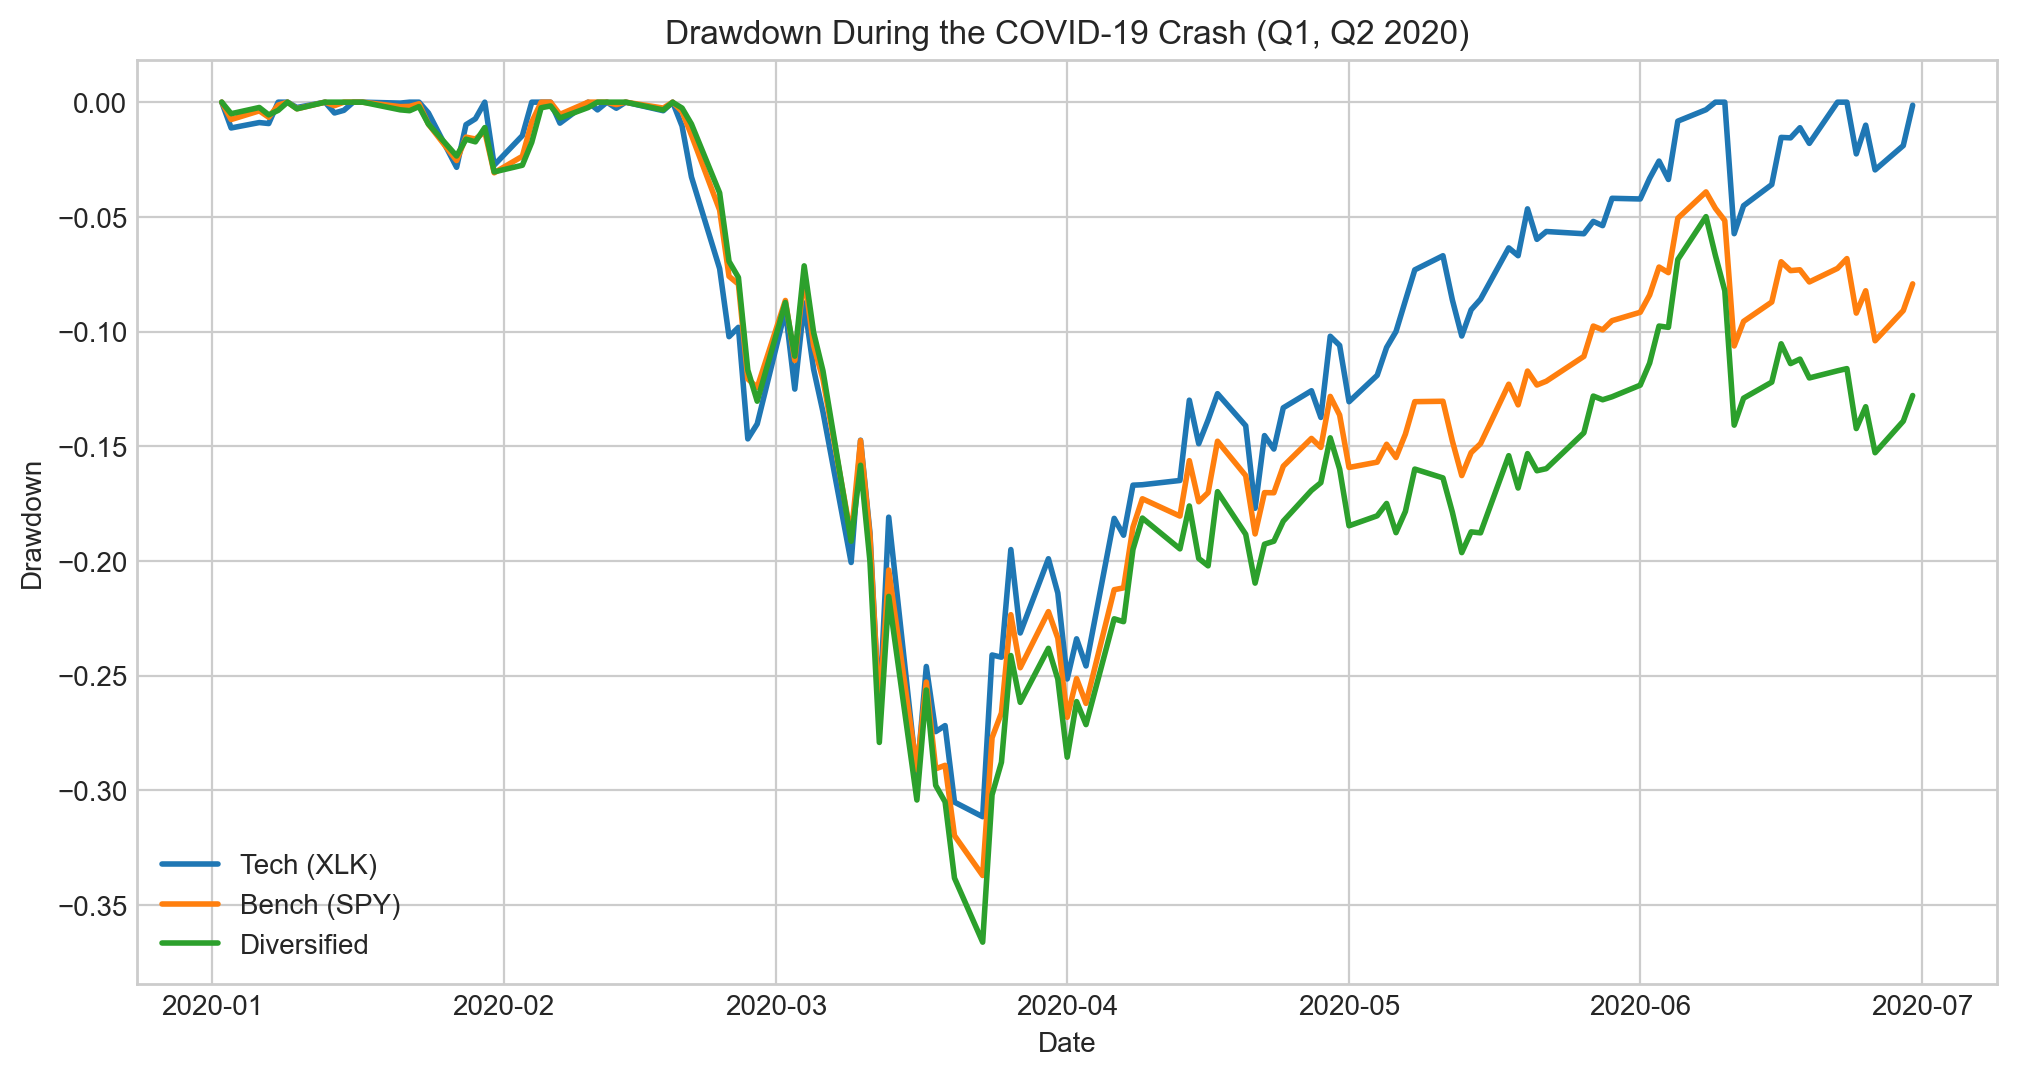

In [10]:
drawdown_series = pd.DataFrame({
    'tech_dd': tech_dd_series,
    'bench_dd': bench_dd_series,
    'div_dd': div_dd_series
})

mask_h1_2020 = (drawdown_series.index >= '2020-01-01') & (drawdown_series.index < '2020-07-01') #mask for the first half of 2020
dd_h1_2020 = drawdown_series.loc[mask_h1_2020]

plt.plot(dd_h1_2020['tech_dd'], label='All-Tech (XLK)', linewidth=2)
plt.plot(dd_h1_2020['bench_dd'], label='Benchmark (SPY)', linewidth=2)
plt.plot(dd_h1_2020['div_dd'], label='Diversified', linewidth=2)

plt.title('Drawdown During the COVID-19 Crash (Q1, Q2 2020)')
plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

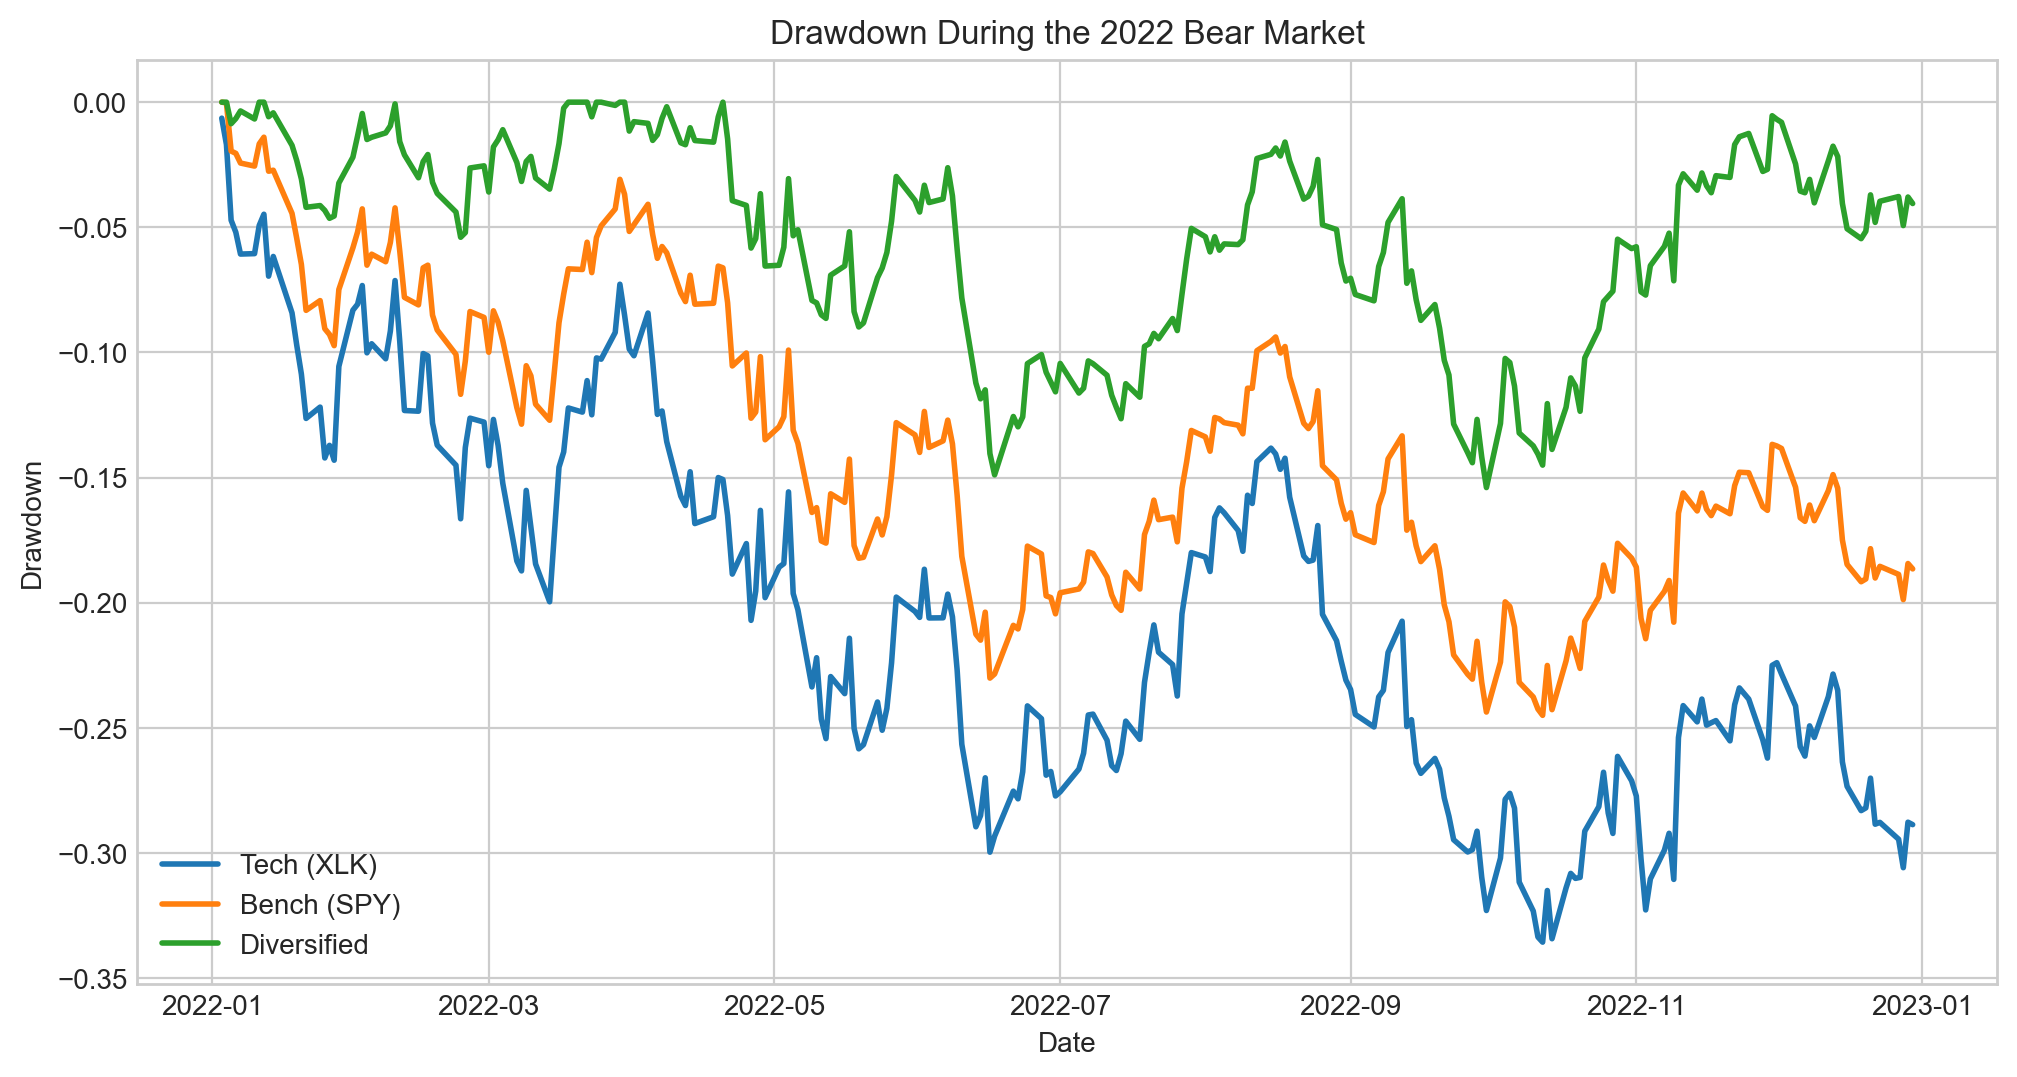

In [11]:
mask_2022 = (drawdown_series.index >= '2022-01-01') & (drawdown_series.index < '2023-01-01') #mask to filter for dates in 2022
dd_2022 = drawdown_series.loc[mask_2022]

plt.plot(dd_2022['tech_dd'], label='All-Tech (XLK)', linewidth=2)
plt.plot(dd_2022['bench_dd'], label='Benchmark (SPY)', linewidth=2)
plt.plot(dd_2022['div_dd'], label='Diversified', linewidth=2)

plt.title('Drawdown During the 2022 Bear Market')
plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

Surprisingly, the Maximum Drawdowns for the all-tech and diversified portfolios occurred in different periods. The diversified portfolio's worst loss happened during the COVID-19 crash. This illustrates a key limitation of diversification: during a true systemic crisis that impacts all sectors simultaneously, such as the sudden supply chain, demand, and operational shocks seen in 2020, correlations between assets can converge toward 1. This means even a well-diversified portfolio may not provide protection, as seen in the sharp, simultaneous decline across industrial, consumer, and other sectors. 
This stands in contrast to the tech portfolio's maximum drawdown, which occurred later, during the 2022 bear market. This period was driven not by a universal shock, but by idiosyncratic risks—risks specific to particular sectors or factors. The 2022 bear market was primarily caused by central banks raising interest rates to combat inflation. This is a macroeconomic policy risk that affects sectors very differently:
- High-growth, long-duration assets like technology stocks (XLK) are severely impacted, as their valuations are more sensitive to higher discount rates,
- Defensive sectors like Utilities (XLU) and Consumer Staples (XLP), which are less rate-sensitive, provided stability,
- Energy (XLE) even benefited from the inflationary environment.
Next, we will take a closer look at the risk vs return dynamics by comparing key metrics such us Sharpe Ratio and Sortino Ratio. For risk-free rate, a 10-year US treasury bond rates were used.

In [12]:
#Sharpe Ratio calculations:
tech_annualized_return = (1 + tech_returns.mean())**252 - 1 #geometric annualized portfolio return for Sharpe Ratio calc
bench_annualized_return = (1 + bench_returns.mean())**252 - 1
div_annualized_return = (1 + div_returns.mean())**252 - 1

print(f'Average annual return on all-tech (XLK) portfolio: {tech_annualized_return:.2%} \nAverage annual return on benchmark (SPY) portfolio: {bench_annualized_return:.2%} \nAverage annual return on diversified portfolio: {div_annualized_return:.2%}')

Average annual return on tech only (XLK) portfolio: 23.45% 
Average annual return on benchmark (SPY) portfolio: 14.88% 
Average annual return on diversified portfolio: 13.02%


In [31]:
#10-year US treasury bond daily rate download
TNX = yf.download('^TNX', start = start_date, end = end_date, auto_adjust = False)['Close']
TNX = TNX.sort_index()
TNX.head()

[*********************100%***********************]  1 of 1 completed


Ticker,^TNX
Date,
2014-01-02,2.985
2014-01-03,2.995
2014-01-06,2.961
2014-01-07,2.937
2014-01-08,2.993


In [14]:
#Sharpe Ratio calculations continued:
average_tnx_yield = TNX.mean().iloc[0]/100

tech_sharpe = (tech_annualized_return - average_tnx_yield)/tech_annual_volatility
bench_sharpe = (bench_annualized_return - average_tnx_yield)/bench_annual_volatility
div_sharpe = (div_annualized_return - average_tnx_yield)/div_annual_volatility

print(f'Sharpe Ratio for all-tech (XLK) portfolio: {tech_sharpe:.2} \nSharpe Ratio for benchmark (SPY) portfolio: {bench_sharpe:.2} \nSharpe Ratio for diversified portfolio: {div_sharpe:.2}')

Sharpe Ratio for tech only (XLK) portfolio: 0.93 
Sharpe Ratio for benchmark (SPY) portfolio: 0.72 
Sharpe Ratio for diversified portfolio: 0.64


In [15]:
#Sortino Ratio calculations:
MAR = average_tnx_yield #define minimum acceptable return, decimal
tech_excess_returns = tech_returns - MAR
bench_excess_returns = bench_returns - MAR
div_excess_returns = div_returns - MAR

tech_downside_returns = tech_excess_returns[tech_excess_returns < 0]
bench_downside_returns = bench_excess_returns[bench_excess_returns < 0]
div_downside_returns = div_excess_returns[div_excess_returns < 0]

tech_downside_deviation_annualized = tech_downside_returns.std() * np.sqrt(252)
bench_downside_deviation_annualized = bench_downside_returns.std() * np.sqrt(252)
div_downside_deviation_annualized = div_downside_returns.std() * np.sqrt(252)

tech_sortino = (tech_annualized_return - average_tnx_yield)/tech_downside_deviation_annualized
bench_sortino = (bench_annualized_return - average_tnx_yield)/bench_downside_deviation_annualized
div_sortino = (div_annualized_return - average_tnx_yield)/div_downside_deviation_annualized

print(f'Sortino Ratio for all-tech (XLK) portfolio: {tech_sortino:.2} \nSortino Ratio for benchmark (SPY) portfolio: {bench_sortino:.2} \nSortino Ratio for diversified portfolio: {div_sortino:.2}')

Sortino Ratio for tech only (XLK) portfolio: 1.1 
Sortino Ratio for benchmark (SPY) portfolio: 0.79 
Sortino Ratio for diversified portfolio: 0.71


The all-tech portfolio (XLK) demonstrated superior risk-adjusted performance, with a Sharpe ratio of 0.93 that significantly outpaced the diversified portfolio's 0.64, which is even below the market during that period. More importantly, the gap between its Sortino ratio (1.10) and Sharpe ratio reveals a critical nuance: a substantial portion of the tech portfolio's total volatility was actually 'good' volatility from upside moves. This created a favorably skewed return profile. In contrast, the diversified portfolio's ratios are much closer together, confirming its more symmetrical and predictable, though much less profitable. Let's actually see 12-Month rolling plots of these metrics.

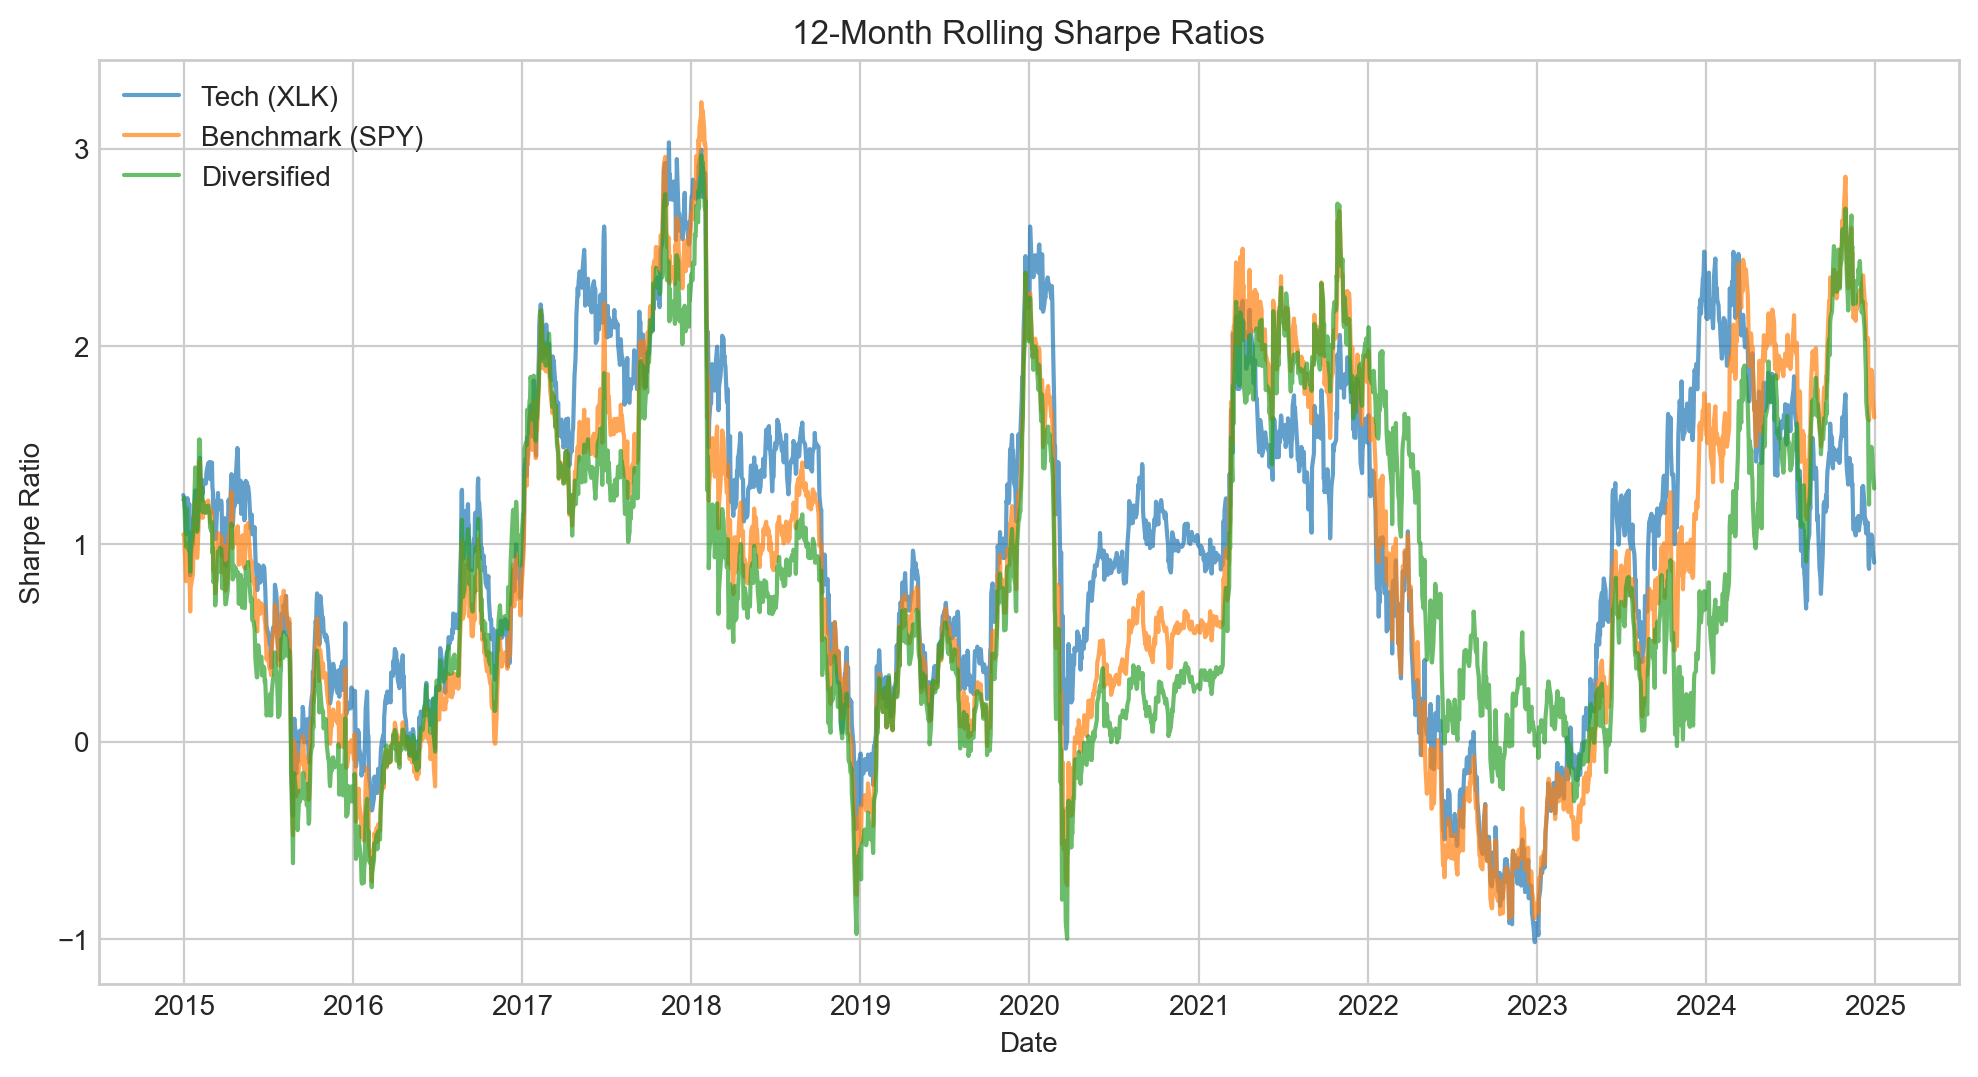

In [16]:
#rolling Sharpe Ratios calculations
tech_rolling_returns = tech_returns.rolling(window = 252)
bench_rolling_returns = bench_returns.rolling(window = 252)
div_rolling_returns = div_returns.rolling(window = 252)

tech_rolling_sharpe = (tech_rolling_returns.mean()*252 - average_tnx_yield)/(tech_rolling_returns.std()*np.sqrt(252))
bench_rolling_sharpe = (bench_rolling_returns.mean()*252 - average_tnx_yield)/(bench_rolling_returns.std()*np.sqrt(252))
div_rolling_sharpe = (div_rolling_returns.mean()*252 - average_tnx_yield)/(div_rolling_returns.std()*np.sqrt(252))

plt.plot(tech_rolling_sharpe, label='Tech (XLK)', alpha=0.7)
plt.plot(bench_rolling_sharpe, label='Benchmark (SPY)', alpha=0.7)
plt.plot(div_rolling_sharpe, label='Diversified', alpha=0.7)
plt.title('12-Month Rolling Sharpe Ratios')
plt.ylabel('Sharpe Ratio')
plt.xlabel('Date')
plt.legend()
plt.show()

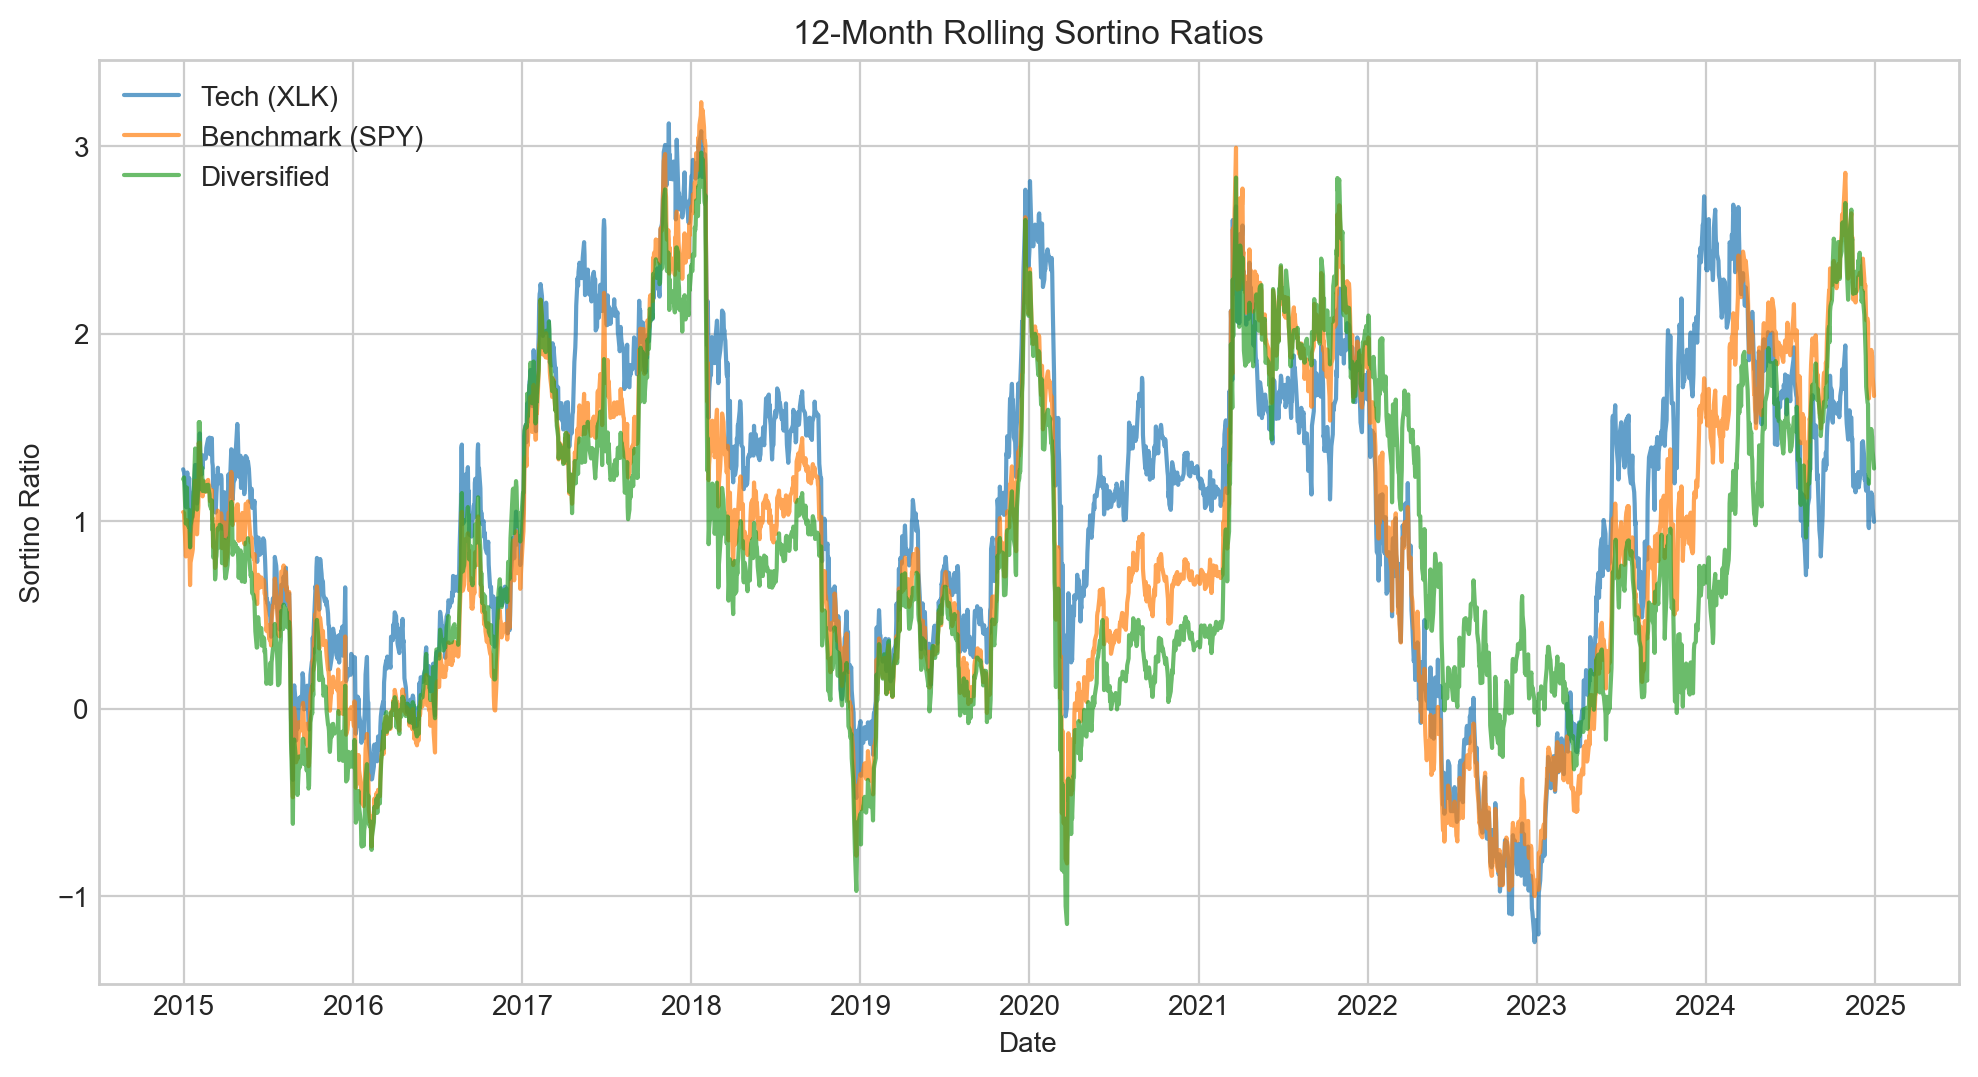

In [17]:
#rolling Sortino Ratios calculations
tech_rolling_downside_deviation = tech_rolling_returns.apply(lambda x: downside_deviation(x, MAR))
bench_rolling_downside_deviation = bench_rolling_returns.apply(lambda x: downside_deviation(x, MAR))
div_rolling_downside_deviation = div_rolling_returns.apply(lambda x: downside_deviation(x, MAR))

tech_rolling_sortino = (tech_rolling_returns.mean()*252 - average_tnx_yield)/(tech_rolling_downside_deviation * np.sqrt(252))
bench_rolling_sortino = (bench_returns.rolling(window = 252).mean()*252 - average_tnx_yield)/(bench_rolling_downside_deviation * np.sqrt(252))
div_rolling_sortino = (div_returns.rolling(window = 252).mean()*252 - average_tnx_yield)/(div_rolling_downside_deviation * np.sqrt(252))

plt.plot(tech_rolling_sortino, label='Tech (XLK)', alpha=0.7)
plt.plot(bench_rolling_sortino, label='Benchmark (SPY)', alpha=0.7)
plt.plot(div_rolling_sortino, label='Diversified', alpha=0.7)
plt.title('12-Month Rolling Sortino Ratios')
plt.ylabel('Sortino Ratio')
plt.xlabel('Date')
plt.legend()
plt.show()

The rolling analysis reveals that the leadership in risk-adjusted returns was not constant. The technology portfolio maintained higher ratios throughout the extended bull market. However, a notable regime shift occurred during the 2022 bear market, where the diversified portfolio's rolling Sharpe and Sortino ratios exceeded those of the tech portfolio for a sustained period.
This demonstrates that the benefit of the diversified strategy was conditional on the market environment. It did not offer superior average efficiency, but it provided a specific advantage during a market downturn driven by sector-specific pressures, which aligns with the theoretical goal of diversification. 
The analysis showed the diversified portfolio provided defensive benefits during the 2022 bear market. But what drove this result? The covariance matrix allows us to quantify the relationships between the assets in the portfolio.
In essence, it measures how the different sector ETFs moved in relation to each other. The goal of diversification is to combine assets with low or negative covariance.

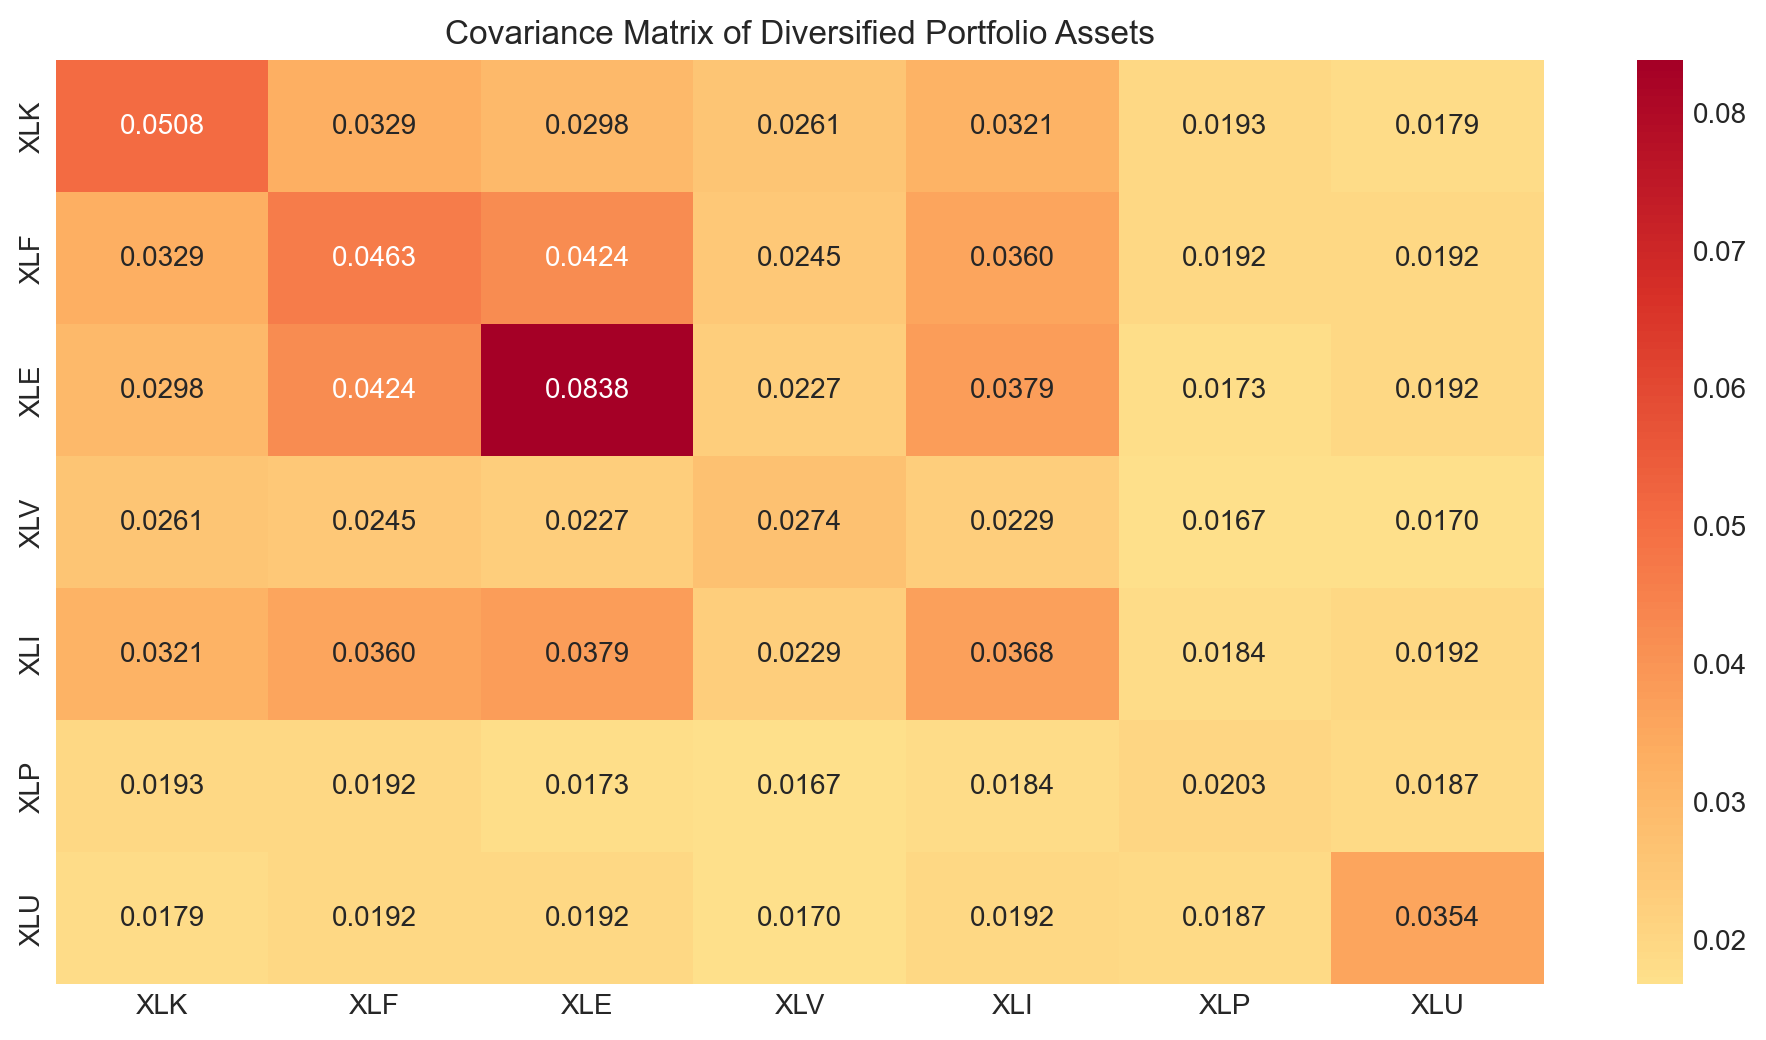

In [18]:
covariance_matrix = returns_df[div_tickers].cov()*252
sns.heatmap(covariance_matrix, 
            annot=True,
            fmt='.4f',
            cmap='RdYlGn_r',
            center=0)
plt.title('Covariance Matrix of Diversified Portfolio Assets')
plt.show()

The result is surprising: all pairwise covariances are positive. This appears to contradict classic diversification theory: if all assets move together, how can combining them reduce risk?
The universally positive covariance over this 10-year period is likely influenced by correlation regime shifts, particularly the extreme market stress of the March 2020 COVID-19 crash. During such systemic panics, correlations between all risky assets spike towards +1. This short-term event can dominate the calculation of a long-term average.

This highlights why professionals often avoid using a single, full-period covariance matrix for forward-looking analysis. It may overstate the average interconnectedness by giving equal weight to a brief crisis period and years of normal market behavior. The protection seen in 2022 suggests that under normal—or sector-specific stress—conditions, the diversifying relationships between these assets are more effective than this long-term matrix implies.

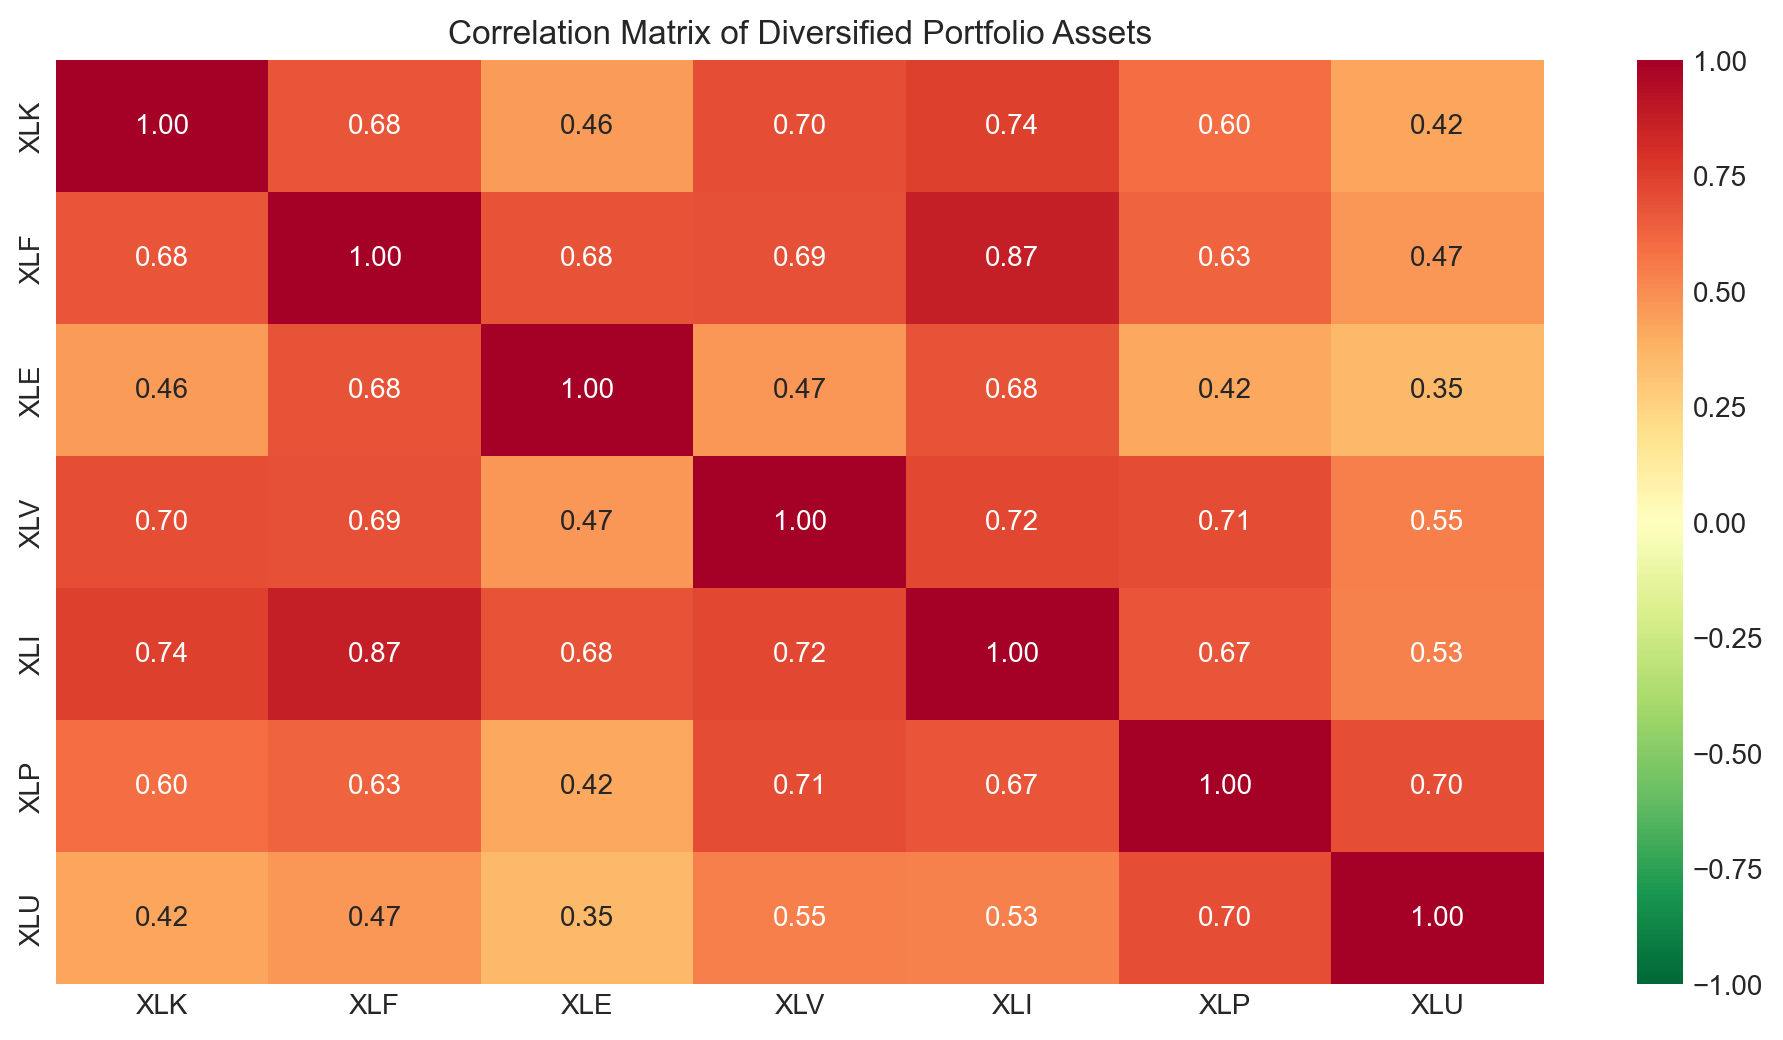

In [19]:
correlation_matrix = returns_df[div_tickers].corr()
sns.heatmap(correlation_matrix, 
            annot=True,
            fmt='.2f',
            cmap='RdYlGn_r',
            center=0,
            vmin=-1,
            vmax=1)
plt.title('Correlation Matrix of Diversified Portfolio Assets')
plt.show()

In [20]:
#efficient frontier calculations
ef_expected_returns = returns_df[div_tickers].mean() * 252
np.random.seed(41)
num_port = 50000
ef_all_weights_arr = np.zeros((num_port, len(div_tickers)))
ef_returns_arr = np.zeros(num_port)
ef_vol_arr = np.zeros(num_port)
ef_sharpe_arr = np.zeros(num_port)

for i in range(num_port):
    ef_weights = np.random.random(len(div_tickers))
    ef_weights /= np.sum(ef_weights)
    
    ef_all_weights_arr[i,:] = ef_weights
    ef_returns_arr[i] = np.sum(np.multiply(ef_expected_returns, ef_weights))
    ef_vol_arr[i] = np.sqrt(np.dot(ef_weights.T, np.dot(covariance_matrix, ef_weights)))
    ef_sharpe_arr[i] = (ef_returns_arr[i] - average_tnx_yield)/ef_vol_arr[i]

In [21]:
print(f'Max Sharpe Ratio for diversified portfolios: {ef_sharpe_arr.max():.2}')
print('Target weights for achieving max Sharpe Ratio in the diversified portfolio: ')
for i in range(len(div_tickers)):
    print(f'{div_tickers[i]} {ef_all_weights_arr[ef_sharpe_arr.argmax(),i]:.2}')
max_sr_vol = ef_vol_arr[ef_sharpe_arr.argmax()]
max_sr_returns = ef_returns_arr[ef_sharpe_arr.argmax()]

Max Sharpe Ratio for diversified portfolios: 0.81
Target weights for achieving max Sharpe Ratio in the diversified portfolio: 
XLK 0.57
XLF 0.035
XLE 0.0052
XLV 0.043
XLI 0.045
XLP 0.083
XLU 0.22


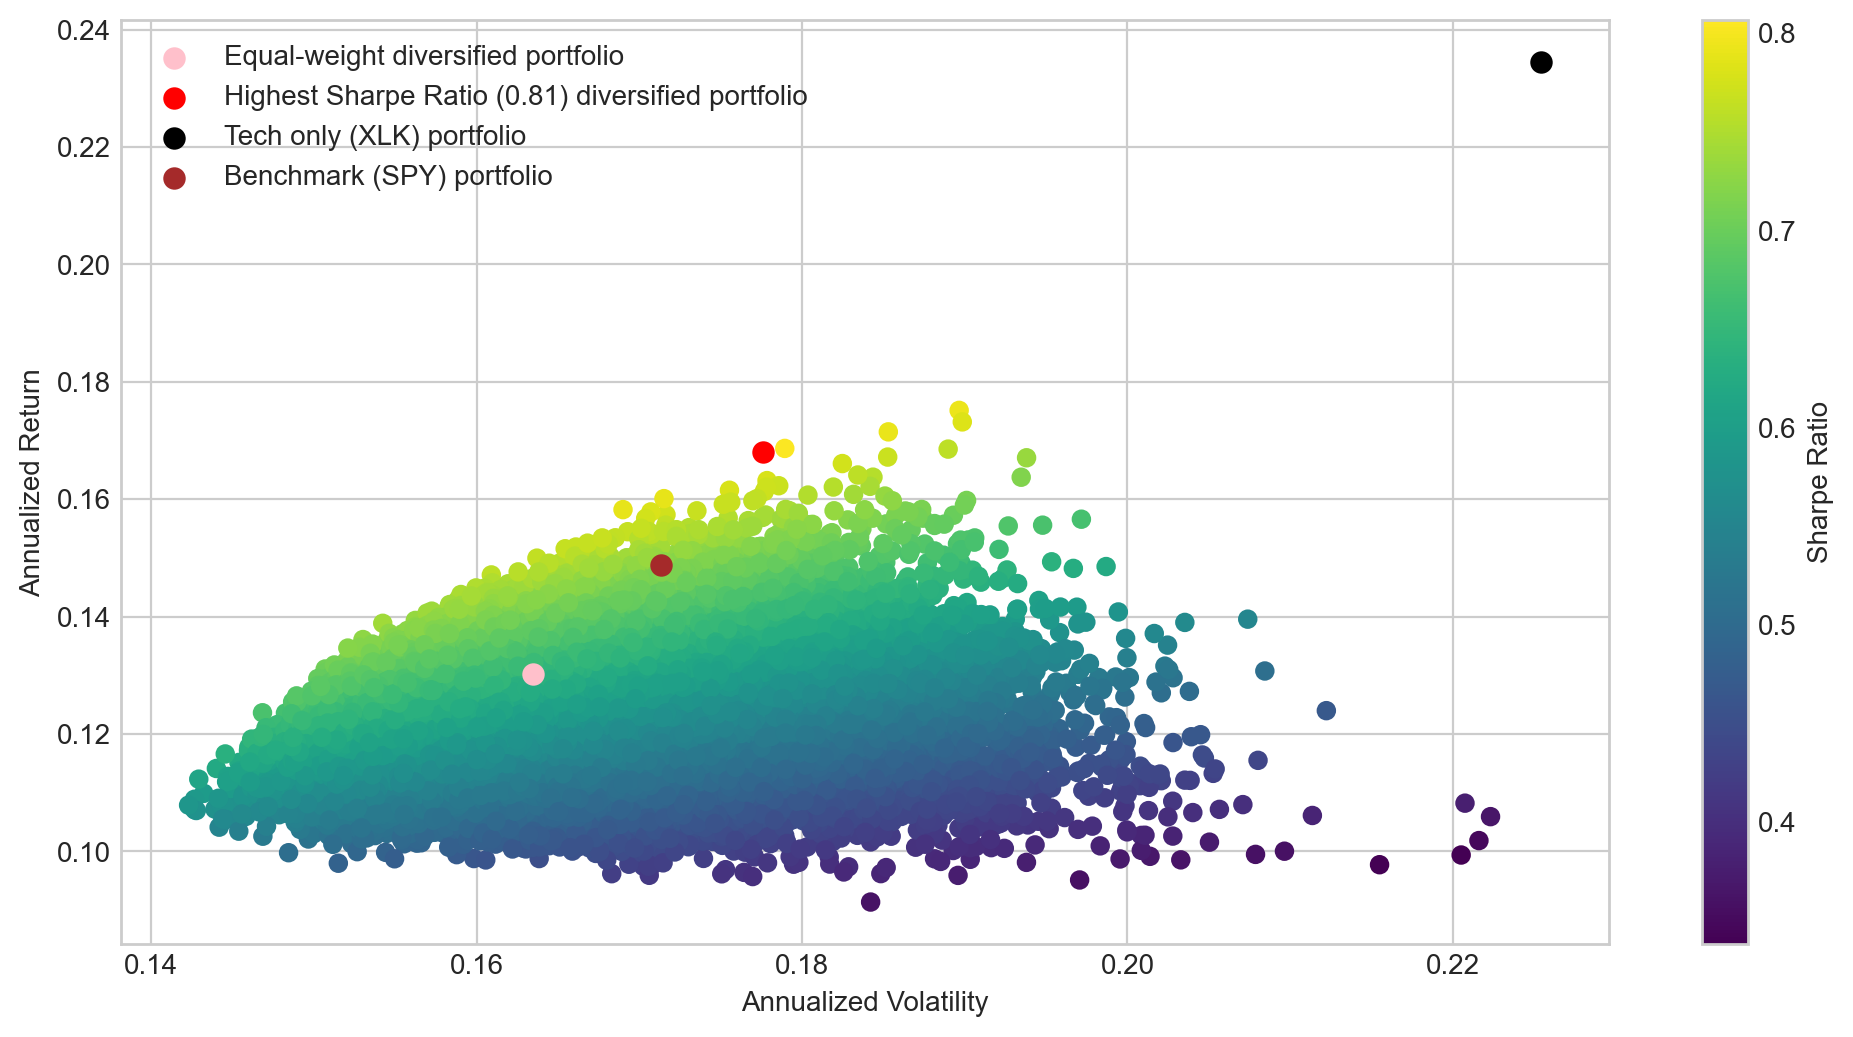

In [22]:
plt.scatter(ef_vol_arr, ef_returns_arr, c = ef_sharpe_arr, cmap = 'viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.scatter(div_annual_volatility, div_annualized_return, c = "pink", s = 50, label = 'Equal-weight diversified portfolio')
plt.scatter(max_sr_vol, max_sr_returns,c = 'red', s = 50, label = 'Highest Sharpe Ratio (0.81) diversified portfolio')
plt.scatter(tech_annual_volatility, tech_annualized_return, c = "black", s = 50, label = 'Tech only (XLK) portfolio')
plt.scatter(bench_annual_volatility, bench_annualized_return, c = "brown", s = 50, label = 'Benchmark (SPY) portfolio')
plt.legend()
plt.show()

In [23]:
# Download the Fama-French 5 factors (monthly data)
ff_factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', datetime.strptime(start_date, '%Y-%m-%d'), datetime.strptime(end_date, '%Y-%m-%d'))[0]
# The [0] selects the first element, which is the DataFrame of factor returns

# Convert from percent to decimal (optional, but matches your return data)
ff_factor_data = ff_factor_data / 100
ff_factor_data.index = ff_factor_data.index.strftime('%Y-%m')
# Display the data
print(ff_factor_data.head())

         Mkt-RF     SMB     HML     RMW     CMA   RF
Date                                                
2014-01 -0.0330  0.0060 -0.0199 -0.0391 -0.0154  0.0
2014-02  0.0468  0.0013 -0.0035 -0.0025 -0.0054  0.0
2014-03  0.0041 -0.0113  0.0490  0.0202  0.0192  0.0
2014-04 -0.0019 -0.0407  0.0122  0.0340  0.0093  0.0
2014-05  0.0204 -0.0186 -0.0010 -0.0009 -0.0096  0.0


C:\Users\Dell\AppData\Local\Temp\ipykernel_9796\2038340406.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', datetime.strptime(start_date, '%Y-%m-%d'), datetime.strptime(end_date, '%Y-%m-%d'))[0]
C:\Users\Dell\AppData\Local\Temp\ipykernel_9796\2038340406.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', datetime.strptime(start_date, '%Y-%m-%d'), datetime.strptime(end_date, '%Y-%m-%d'))[0]


In [24]:
tech_monthly_returns = tech_equity.resample('ME').last().pct_change().dropna()
tech_monthly_returns.index = tech_monthly_returns.index.strftime('%Y-%m')
div_monthly_returns = div_equity.resample('ME').last().pct_change().dropna()
div_monthly_returns.index = div_monthly_returns.index.strftime('%Y-%m')
bench_monthly_returns = bench_equity.resample('ME').last().pct_change().dropna()
bench_monthly_returns.index = bench_monthly_returns.index.strftime('%Y-%m')

C:\Users\Dell\AppData\Local\Temp\ipykernel_9796\141108223.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  div_monthly_returns = div_equity.resample('ME').last().pct_change().dropna()


In [25]:
# Align the dates of your portfolio returns with the Fama-French data
# This ensures you have matching time periods for the regression
tech_common_index = tech_monthly_returns.index.intersection(ff_factor_data.index)
tech_returns_aligned = tech_monthly_returns.loc[tech_common_index]
tech_ff_data_aligned = ff_factor_data.loc[tech_common_index]

# Define the independent variables (the 5 factors) and add a constant (alpha)
X = sm.add_constant(tech_ff_data_aligned[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]) # Market, Size, Value, Profitability, Investment
y = tech_returns_aligned - tech_ff_data_aligned['RF']  # Dependent variable: Portfolio excess return

# Create and fit the regression model
model = sm.OLS(y, X).fit()

# Print the detailed regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     195.5
Date:                Thu, 25 Sep 2025   Prob (F-statistic):           2.61e-57
Time:                        18:35:12   Log-Likelihood:                 342.03
No. Observations:                 131   AIC:                            -672.1
Df Residuals:                     125   BIC:                            -654.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.002      1.851      0.0

In [26]:
# Align the dates of your portfolio returns with the Fama-French data
# This ensures you have matching time periods for the regression
div_common_index = div_monthly_returns.index.intersection(ff_factor_data.index)
div_returns_aligned = div_monthly_returns.loc[div_common_index]
div_ff_data_aligned = ff_factor_data.loc[div_common_index]

# Define the independent variables (the 5 factors) and add a constant (alpha)
X = sm.add_constant(div_ff_data_aligned[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]) # Market, Size, Value, Profitability, Investment
y = div_returns_aligned - div_ff_data_aligned['RF']  # Dependent variable: Portfolio excess return

# Create and fit the regression model
model = sm.OLS(y, X).fit()

# Print the detailed regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     476.7
Date:                Thu, 25 Sep 2025   Prob (F-statistic):           1.39e-79
Time:                        18:35:12   Log-Likelihood:                 429.78
No. Observations:                 131   AIC:                            -847.6
Df Residuals:                     125   BIC:                            -830.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.424      0.6